# Optional part: 2 and 3

In [1]:
from NeuralNet import NeuralNet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from itertools import product
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('data_clean.csv')
df = df.select_dtypes(include = ['float64', 'int64'])

y = df['SalePrice'].values
X = df.drop('SalePrice', axis=1).values

### Optional part 2

We used a 5-fold cross validation where 80% of the patterns were used for training and the remaining 20% for testing. The data were shuffled before splitting and random_state was set to 42. For each combination of Neural Network hyperparameters, one model was trained on each fold, and MSE, MAE, and MAPE metrics were calculated. Finally, the mean of these metrics was obtained across the five folds.

In [3]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = [] 

# Hyperparameters for the Grid Search
grid_parameters = { 
    'epochs': [300, 500],
    'learning_rate': [0.01, 0.001],
    'function': ['relu', 'tanh'],
}

# For loop for the different hyperparameter combinations
for epochs, lr, func in product(grid_parameters['epochs'],
                                grid_parameters['learning_rate'],
                                grid_parameters['function']):
    fold_mse = []
    fold_mae = []
    fold_mape = []
    fold = 1
    print(f"Evaluating combination: epochs={epochs}, lr={lr}, func={func}")

    # For loop for the cross validation
    for train_index, test_index in kf.split(X):
        
        # Dataset division by folds
        X_train_kf = X[train_index]    
        X_test_kf  = X[test_index]
        y_train_kf = y[train_index]
        y_test_kf  = y[test_index]

        # Once we have split the data, we normalize it

        # Make sure y is a column for the correct use of MinMaxScaler
        y_train_col = y_train_kf.reshape(-1, 1)
        y_test_col  = y_test_kf.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_tr_s = scaler_X.fit_transform(X_train_kf)
        y_tr_s = scaler_y.fit_transform(y_train_col)

        X_test_s = scaler_X.transform(X_test_kf)
        y_test_s = scaler_y.transform(y_test_col)


        # NN with the hyperparameters for this grid point
        nn_kf = NeuralNet(
            layers=[X_tr_s.shape[1], 64, 32, 1],
            epochs=epochs,
            learning_rate=lr,
            function=func
        )

        nn_kf.fit(X_tr_s, y_tr_s)
        preds = nn_kf.predict(X_test_s)

        preds = np.asarray(preds).reshape(-1)
        yn_test_kf = np.asarray(y_test_s).reshape(-1)

        # Metrics are calculated for each fold
        fold_mse.append(mean_squared_error(preds, yn_test_kf))
        fold_mae.append(mean_absolute_error(preds, yn_test_kf))
        mape = np.mean(np.abs((yn_test_kf - preds) / yn_test_kf)) * 100
        fold_mape.append(mape)

        fold += 1

    # Mean of all metrics for each cross validation
    fold_mse_value = np.mean(fold_mse)
    fold_mae_value = np.mean(fold_mae)
    fold_mape_value = np.mean(fold_mape)

    # Results
    combo_key = f"epochs={epochs}_lr={lr}_func={func}"
    results.append({    
        'combo': combo_key,
        'epochs': epochs,
        'learning_rate': lr,
        'function': func,
        'mse': fold_mse_value,
        'mae': fold_mae_value,
        'mape': fold_mape_value
    })



Evaluating combination: epochs=300, lr=0.01, func=relu
Epoch 0/300 - Training Error: 0.240686 - Validation Error: 0.229420
Epoch 100/300 - Training Error: 0.240686 - Validation Error: 0.229420
Epoch 200/300 - Training Error: 0.240686 - Validation Error: 0.229420
Epoch 0/300 - Training Error: 0.233878 - Validation Error: 0.243923
Epoch 100/300 - Training Error: 0.233878 - Validation Error: 0.243923
Epoch 200/300 - Training Error: 0.233878 - Validation Error: 0.243923
Epoch 0/300 - Training Error: 0.014825 - Validation Error: 0.021301
Epoch 100/300 - Training Error: 0.001045 - Validation Error: 0.009022
Epoch 200/300 - Training Error: 0.000521 - Validation Error: 0.009341
Epoch 0/300 - Training Error: 0.013751 - Validation Error: 0.014298
Epoch 100/300 - Training Error: 0.001457 - Validation Error: 0.005788
Epoch 200/300 - Training Error: 0.000898 - Validation Error: 0.006293
Epoch 0/300 - Training Error: 0.229237 - Validation Error: 0.231754
Epoch 100/300 - Training Error: 0.229237 - Va

In [4]:
results_sorted = sorted(results, key=lambda x: x['mse'])
for r in results_sorted:
    print(f"{r['combo']}: MSE={r['mse']:.4f}, MAE={r['mae']:.4f}, MAPE={r['mape']:.4f}")

epochs=300_lr=0.01_func=tanh: MSE=0.0052, MAE=0.0503, MAPE=17.2443
epochs=500_lr=0.001_func=tanh: MSE=0.0055, MAE=0.0537, MAPE=18.2950
epochs=500_lr=0.01_func=tanh: MSE=0.0057, MAE=0.0540, MAPE=18.9146
epochs=300_lr=0.001_func=tanh: MSE=0.0057, MAE=0.0544, MAPE=18.5369
epochs=500_lr=0.001_func=relu: MSE=0.0518, MAE=0.1323, MAPE=33.5393
epochs=300_lr=0.001_func=relu: MSE=0.0525, MAE=0.1353, MAPE=34.8788
epochs=300_lr=0.01_func=relu: MSE=0.1392, MAE=0.2865, MAPE=68.1652
epochs=500_lr=0.01_func=relu: MSE=0.1409, MAE=0.2897, MAPE=68.9095


In [5]:
df_results = pd.DataFrame(results_sorted)
df_results

,combo,epochs,learning_rate,function,mse,mae,mape
0,epochs=300_lr=0.01_func=tanh,300,0.010,tanh,0.005153,0.050294,17.244310
1,epochs=500_lr=0.001_func=tanh,500,0.001,tanh,0.005484,0.053655,18.295007
2,epochs=500_lr=0.01_func=tanh,500,0.010,tanh,0.005674,0.053980,18.914605
3,epochs=300_lr=0.001_func=tanh,300,0.001,tanh,0.005707,0.054443,18.536919
4,epochs=500_lr=0.001_func=relu,500,0.001,relu,0.051812,0.132310,33.539258
5,epochs=300_lr=0.001_func=relu,300,0.001,relu,0.052454,0.135333,34.878803
6,epochs=300_lr=0.01_func=relu,300,0.010,relu,0.139235,0.286451,68.165195
7,epochs=500_lr=0.01_func=relu,500,0.010,relu,0.140879,0.289689,68.909453


We can observe that the 'tanh' activation function performs better than 'relu', using the lowest largest learning rate and the smallest number of epochs defined.

### Optional part 3

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = MinMaxScaler()

Xn_train = scaler_X.fit_transform(X_train)
Xn_test = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()

yn_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
yn_test  = scaler_y.transform(y_test.reshape(-1, 1))

yn_train = yn_train.ravel()
yn_test = yn_test.ravel()

#### XGBoost

The XGBoost Regressor (eXtreme Gradient Boosting Regressor) is a optimized implementation of the Gradient Boosting algorithm, which works by building an ensemble of weak learners (typically shallow Decision Trees) in a sequential, additive manner. Instead of training all trees independently, each new tree is built to correct the residual errors (the difference between the target value and the current ensemble's prediction) of the previous trees by fitting to the negative gradient of the loss function . This process incrementally improves the model, and XGBoost further enhances performance through advanced techniques like regularization (L1 and L2) to prevent overfitting, parallel processing of tree construction, and sophisticated tree pruning. For the initial setup, a baseline model was created using the same parameters as Random Forest.

#### Before Grid search

In [7]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=300, random_state=42)
xgb_model.fit(Xn_train, yn_train)
xgb_predictions = xgb_model.predict(Xn_test)

mse_xgb = mean_squared_error(yn_test, xgb_predictions)
r2_score_xgb = r2_score(yn_test, xgb_predictions)

print(f"XGBoost MSE: {mse_xgb:.4f}")
print(f"XGBoost R2 Score: {r2_score_xgb:.4f}")

XGBoost MSE: 0.0052
XGBoost R2 Score: 0.8477


Text(0.5, 1.0, 'XGBoost: Real vs Predicted values before Grid Search')

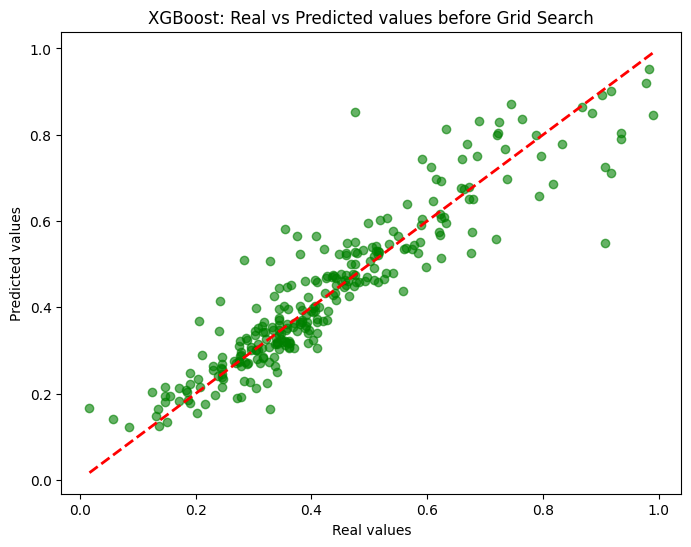

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(yn_test, xgb_predictions, alpha=0.6, color='green')
plt.plot([yn_test.min(), yn_test.max()], [yn_test.min(), yn_test.max()], 'r--', lw=2)
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.title('XGBoost: Real vs Predicted values before Grid Search')

#### After grid search

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [300, 600, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 6, 8]
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(random_state=42), param_grid=param_grid)
grid_search.fit(Xn_train, yn_train)

grid_search.best_params_
best_xgb_model = grid_search.best_estimator_
print("Best XGBoost Parameters:", grid_search.best_params_)

best_xgb_predictions = best_xgb_model.predict(Xn_test)

best_mse_xgb = mean_squared_error(yn_test, best_xgb_predictions)
best_r2_score_xgb = r2_score(yn_test, best_xgb_predictions)

print(f"Best XGBoost MSE after Grid Search: {best_mse_xgb:.4f}")
print(f"Best XGBoost R2 Score after Grid Search: {best_r2_score_xgb:.4f}")

Best XGBoost Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 600}
Best XGBoost MSE after Grid Search: 0.0041
Best XGBoost R2 Score after Grid Search: 0.8788


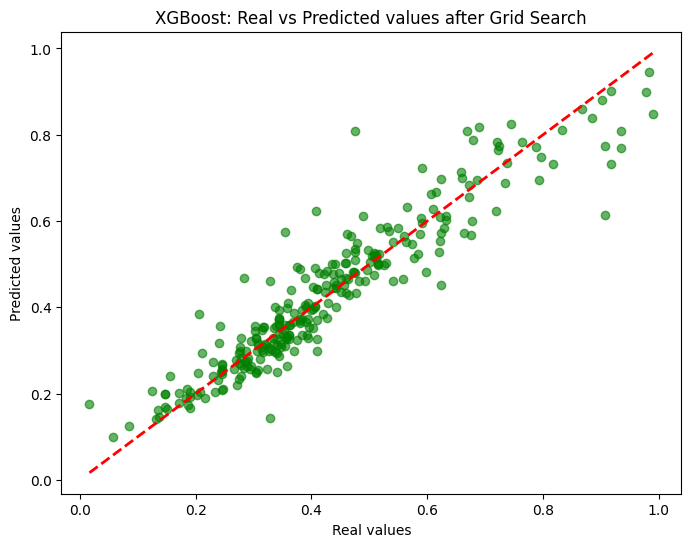

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(yn_test, best_xgb_predictions, alpha=0.6, color='green')
plt.plot([yn_test.min(), yn_test.max()], [yn_test.min(), yn_test.max()], 'r--', lw=2)
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.title('XGBoost: Real vs Predicted values after Grid Search')
plt.show()

#### Random forest regressor

The Random Forest Regressor is an ensemble learning technique that improves prediction accuracy and controls overfitting by combining the results of many individual Decision Trees. It operates on the principle of bagging (Bootstrap Aggregating) by training each tree on a different bootstrap sample of the data (sampling with replacement) and considering only a random subset of features at each node split to ensure the trees are decorrelated . For a regression task, the final predicted value is determined by taking the average of the predictions made by all the individual trees in the forest. For the initial setup, a baseline model was created using the same parameters as XGBoost.

#### Before Grid Search

In [11]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=300, random_state=42)
rf_model.fit(Xn_train, yn_train)
rf_predictions = rf_model.predict(Xn_test)

mse_rf = mean_squared_error(yn_test, rf_predictions)
r2_score_rf = r2_score(yn_test, rf_predictions)

print(f"Random Forest MSE: {mse_rf:.4f}")
print(f"Random Forest R2 Score: {r2_score_rf:.4f}")

Random Forest MSE: 0.0048
Random Forest R2 Score: 0.8606


Text(0.5, 1.0, 'Random Forest: Real vs Predicted values before Grid Search')

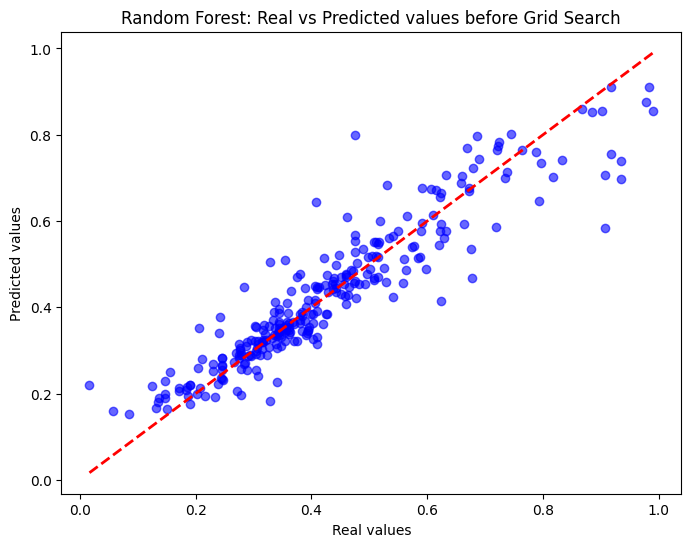

In [12]:
plt.figure(figsize=(8,6))
plt.scatter(yn_test, rf_predictions, alpha=0.6, color='blue')
plt.plot([yn_test.min(), yn_test.max()], [yn_test.min(), yn_test.max()], 'r--', lw=2)
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.title('Random Forest: Real vs Predicted values before Grid Search')

### After Grid Search 

In [13]:
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}

grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid)
grid_search_rf.fit(Xn_train, yn_train)

grid_search_rf.best_params_
best_rf_model = grid_search_rf.best_estimator_
print("Best Random Forest Parameters:", grid_search_rf.best_params_)

best_rf_predictions = best_rf_model.predict(Xn_test)
best_mse_rf = mean_squared_error(yn_test, best_rf_predictions)
best_r2_score_rf = r2_score(yn_test, best_rf_predictions)

print(f"Best Random Forest MSE after Grid Search: {best_mse_rf:.4f}")
print(f"Best Random Forest R2 Score after Grid Search: {best_r2_score_rf:.4f}")

Best Random Forest Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500}
Best Random Forest MSE after Grid Search: 0.0047
Best Random Forest R2 Score after Grid Search: 0.8631


Text(0.5, 1.0, 'Random Forest: Real vs Predicted values after Grid Search')

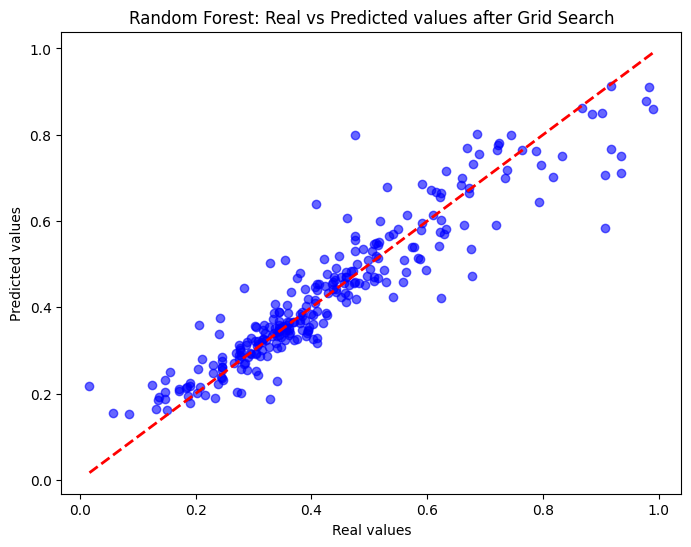

In [14]:
plt.figure(figsize=(8,6))
plt.scatter(yn_test, best_rf_predictions, alpha=0.6, color='blue')
plt.plot([yn_test.min(), yn_test.max()], [yn_test.min(), yn_test.max()], 'r--', lw=2)
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.title('Random Forest: Real vs Predicted values after Grid Search')

We performed a Grid Search for both models to explore the best combination of hyperparameters for each. The main idea was to select starting points for tuning these ensemble methods and to investigate the trade-off between model complexity, learning speed, and generalization ability. We selected similar parameters between the two models and then compared them. As a result we have:

- XGBoost improved significantly after Grid Search, decreasing MSE and encreasing R².
- Random Forest improved only slightly after the grid search.